# Initializations

In [17]:
import os, shutil, importlib
import utils; importlib.reload(utils)

os.environ["CUDA_VISIBLE_DEVICES"]=''

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import h5py
import keras

from glob import glob

from PIL import Image
from os.path import join as jp

from keras import layers, models, optimizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.utils import layer_utils

from scipy import ndimage

from sklearn import metrics

from IPython.display import FileLink


%matplotlib inline
np.set_printoptions(precision=4, linewidth=100)

Structure data

In [2]:
path = '../data/dogscats/'
utils.struct_dir(path, ['cat', 'dog'])

Directory structure already exists


Setup paths

In [3]:
# path = '../data/dogscats/'
path = '../data/dogscats/sample/'
path_model = '../data/dogscats/models/vgg16/'
path_test = path + 'test'
path_train = path + 'train'
path_valid = path + 'valid'
path_img_arrays = path + 'img_arrays/'

path_submit = path_model + 'submissions/'
path_checkpoint = path_model + 'checkpoints/'
path_results = path_model + 'results/'

# Load Model

- Load model and finetune weights

In [4]:
import vgg16; importlib.reload(vgg16)
from vgg16 import Vgg16

In [ ]:
vgg = Vgg16()

Loading model weights


In [ ]:
vgg.ft(2)
vgg.model.load_weights(path_model+'attempt3/checkpoints/weights_conv.h5') 

In [5]:
batch_size = 8

#### Load data and pre-calculate conv features

In [6]:
data_train = utils.load_array_bcolz(path_img_arrays+'train.bc')
data_valid = utils.load_array_bcolz(path_img_arrays+'valid.bc')
classes, filenames = utils.get_classes(path)
labels_train = classes[2]
labels_valid = classes[3]

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


In [12]:
# gen = image.ImageDataGenerator()
# batches_train = gen.flow(data_train, labels_train, batch_size=batch_size, shuffle=False)
# batches_valid = gen.flow(data_valid, labels_valid, batch_size=batch_size, shuffle=False)

In [13]:
# feats_conv_train = vgg_conv.predict_generator(batches_train, batches_train.n)
# feats_conv_valid = vgg_conv.predict_generator(batches_valid, batches_valid.n)

In [14]:
# utils.save_array_bcolz(path_img_arrays+'train_conv.b5', feats_conv_train)
# utils.save_array_bcolz(path_img_arrays+'valid_conv.b5', feats_conv_valid)

In [7]:
feats_conv_train = utils.load_array_bcolz(path_img_arrays+'train_conv.b5')
feats_conv_valid = utils.load_array_bcolz(path_img_arrays+'valid_conv.b5')

In [8]:
feats_conv_train.shape

(100, 14, 14, 512)

# Model Modifications

## Remove Dropout

- Split the model into conv and dense layers
- Precalculate the output of the convs layers
- Create new model with just the dense layers
- Train new model using output of conv layers as features

#### Split Model

In [9]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 226, 226, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 224, 224, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 226, 226, 64)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [20]:
layers_conv, layers_fc = utils.split_at(vgg.model, layers.Conv2D)

In [21]:
vgg_conv = models.Sequential(layers_conv)

#### Create FC Model

Create fc model by creating a new model of the same architecture as the fc portion of VGG16 with dropout p set to 0. Then copy all the weights from the previous dense layers

In [22]:
vgg_fc = utils.create_model_from_layers(layers_fc)

In [23]:
utils.set_dropout(vgg_fc, p_prev=0.5, p_new=0.0)

In [24]:
opt = optimizers.Adam(lr=0.00001)
vgg_fc.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Train FC Model with conv features

In [25]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_fc.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=False, monitor='val_acc')]
vgg_fc.fit(feats_conv_train, labels_train, batch_size=batch_size, nb_epoch=8,
           validation_data=(feats_conv_valid, labels_valid), callbacks=callbacks)

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 13s - loss: 0.1049 - acc: 0.9748 - val_loss: 0.0998 - val_acc: 0.9755

Remove non optimal saved weights

In [29]:
epoch_keep = 1
utils.rm_checkpoints(path_checkpoint+'weights_fc', epoch_keep)

#### Model Checkpoint

In [30]:
vgg_fc.load_weights(glob(path_checkpoint+'weights_fc.*')[0])

#### Create Submission

In [31]:
batches_test, probs_test = vgg.test(path_test, batch_size=batch_size)
np.save(path_results+'filenames_test_fc.npy', batches_test.filenames)
np.save(path_results+'probs_test_fc.npy', probs_test)

Found 12500 images belonging to 1 classes.


In [32]:
utils.create_submit(batches_test, probs_test[:, 1], clip=(0.025, 0.975),
                    fname=path_submit+'submit_fc.csv')

In [33]:
FileLink('../data/dogscats/models/vgg16/submissions/submit_fc.csv')

/home/ubuntu/projects/fast_ai/data/dogscats/models/vgg16/submissions/submit_fc.csv

## Data Aug

- Get image generator, train / valid batches
- Add dense model back onto conv model
- Compile and train (on conv weights from lesson 2 but no dropout)

#### Examples

In [23]:
gen = image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.2, height_shift_range=0.2,
                               shear_range=0.15,
                               zoom_range=0.3,
                               channel_shift_range=10.0,
                               horizontal_flip=True,
                               fill_mode='constant'
                              )

Read in one image and test

In [24]:
img = np.expand_dims(ndimage.imread(path_train + '/cat/cat.400.jpg'), 0)
img.shape

(1, 374, 500, 3)

In [25]:
aug_gen = gen.flow(img)

In [26]:
imgs = [aug_gen.next()[0] for i in range(0, 8)]

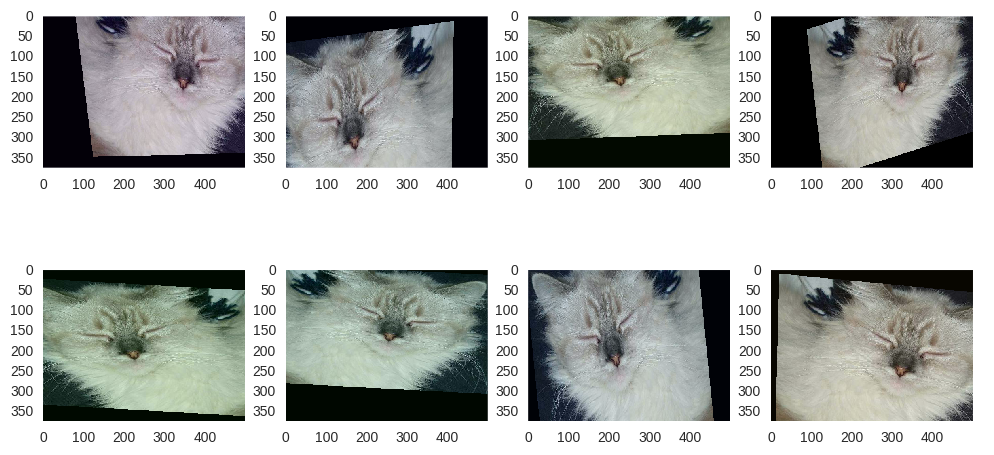

In [27]:
utils.plot_imgs(imgs, rows=2)

#### Generate Batches

In [8]:
# gen = image.ImageDataGenerator(rotation_range=10,
#                                width_shift_range=0.2, height_shift_range=0.2,
#                                shear_range=0.15,
#                                zoom_range=0.3,
#                                channel_shift_range=10.0,
#                                horizontal_flip=True,
#                                fill_mode='constant'
#                               )
gen = image.ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               shear_range=0.05,
                               zoom_range=0.1,
                               channel_shift_range=3.0,
                               horizontal_flip=True,
                               fill_mode='constant'
                              )

In [9]:
batches_train = utils.get_batches(path_train, gen=gen, shuffle=True, 
                                  batch_size=batch_size)
batches_valid = utils.get_batches(path_valid, shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


#### Combine Conv and fc Models

Set conv layers to be untrainable

In [10]:
vgg.model.load_weights(path_model+'attempt3/checkpoints/weights_conv.h5') 

In [11]:
layers_conv, layers_fc = utils.split_at(vgg.model, layers.Conv2D)

In [12]:
vgg_conv = models.Sequential(layers_conv)

In [13]:
for layer in vgg_conv.layers: layer.trainable = False

Create fc layer from dense layers in vgg and remove dropout

In [14]:
vgg_fc = utils.create_model_from_layers(layers_fc)
utils.set_dropout(vgg_fc, p_prev=0.5, p_new=0)
vgg_conv.add(vgg_fc)

#### Compile and Train

In [15]:
opt = optimizers.Adam(lr=0.00001)
vgg_conv.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_aug.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]
vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n,
                       validation_data=batches_valid, nb_val_samples=batches_valid.n,
                       nb_epoch=8, callbacks=callbacks)

Epoch 1/8
23000/23000 [==============================] - 377s - loss: 0.1239 - acc: 0.9699 - val_loss: 0.1003 - val_acc: 0.9735

In [17]:
epoch_keep = 7
utils.rm_checkpoints(path_checkpoint+'weights_ndrop_aug', epoch_keep)

#### Checkpoint

In [24]:
vgg_conv.load_weights(glob(path_checkpoint+'weights_ndrop_aug.*')[0])

#### Create Submission

In [25]:
batches_test, probs_test = vgg.test(path_test, batch_size=batch_size)
np.save(path_results+'filenames_test_ndrop_aug.npy', batches_test.filenames)
np.save(path_results+'probs_test_ndrop_aug.npy', probs_test)

Found 12500 images belonging to 1 classes.


In [22]:
utils.create_submit(batches_test, probs_test[:, 1], clip=(0.02, 0.98),
                    fname=path_submit+'submit_ndrop_aug.csv')

In [23]:
FileLink('../data/dogscats/models/vgg16/submissions/submit_ndrop_aug.csv')

/home/ubuntu/projects/fast_ai/data/dogscats/models/vgg16/submissions/submit_ndrop_aug.csv

## Batch Norm

- Load original weights
- Split conv and fc layers, and create fc model
- Set dropout to 0
- Pop last layer and finetune (last only) using precalculated conv_feats

- Combine fc and conv layers back into one model
- Train on augmented data
- Decrease lr when performance stops improving

#### Split and  Create Models

In [9]:
vgg = Vgg16()

Loading model weights


In [10]:
layers_conv, layers_fc = utils.split_at(vgg.model, layers.Conv2D)

In [11]:
vgg_fc = utils.create_model_from_layers(layers_fc)

In [12]:
utils.set_dropout(vgg_fc, p_prev=0.5, p_new=0)

Insert batchnorm layers after dropout layers

In [13]:
vgg_fc = utils.insert_layers(vgg_fc, layers.BatchNormalization, [4, 6])

Pop last layer and retrain

In [14]:
vgg_fc.pop()
for layer in vgg_fc.layers: layer.trainable = False

In [15]:
vgg_fc.add(layers.Dense(2, activation='softmax'))

#### Compile and Train

In [24]:
vgg_fc.compile(optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
               metrics=['accuracy'])

In [25]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_bn.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]

vgg_fc.fit(feats_conv_train, labels_train, batch_size=batch_size, nb_epoch=4,
           callbacks=callbacks, validation_data=(feats_conv_valid, labels_valid),)

Train on 100 samples, validate on 100 samples
Epoch 1/4
100/100 [==============================] - 7s - loss: 0.5293 - acc: 0.8000 - val_loss: 0.2863 - val_acc: 0.9000
Epoch 2/4
100/100 [==============================] - 2s - loss: 0.1607 - acc: 0.9500 - val_loss: 0.3116 - val_acc: 0.8800
Epoch 3/4
100/100 [==============================] - 2s - loss: 0.1836 - acc: 0.9500 - val_loss: 0.2146 - val_acc: 0.8900
Epoch 4/4
100/100 [==============================] - 6s - loss: 0.2299 - acc: 0.9200 - val_loss: 0.2245 - val_acc: 0.9200


In [27]:
epoch_keep = 4
utils.rm_checkpoints(path_checkpoint+'weights_ndrop_bn', epoch_keep)

#### Checkpoint

In [16]:
vgg_fc.load_weights(glob(path_checkpoint+'weights_ndrop_bn.*')[0])

#### Combine Models

In [18]:
vgg_conv = models.Sequential(layers_conv)
for layer in vgg_conv.layers: layer.trainable = False

Copy just trained vgg_fc model and add its layers ot vgg_conv

In [20]:
for layer in utils.create_model_from_layers(vgg_fc.layers).layers:
    vgg_conv.add(layer)

#### Compile and Train

In [22]:
# gen = image.ImageDataGenerator(rotation_range=10,
#                                width_shift_range=0.2, height_shift_range=0.2,
#                                shear_range=0.15,
#                                zoom_range=0.3,
#                                channel_shift_range=10.0,
#                                horizontal_flip=True,
#                                fill_mode='constant'
#                               )
gen = image.ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               shear_range=0.05,
                               zoom_range=0.1,
                               channel_shift_range=3.0,
                               horizontal_flip=True,
                               fill_mode='constant'
                              )

In [23]:
batches_train = utils.get_batches(path_train, gen=gen, shuffle=True, 
                                  batch_size=batch_size)
batches_valid = utils.get_batches(path_valid, shuffle=False, batch_size=batch_size)

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [25]:
vgg_conv.compile(optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
               metrics=['accuracy'])

In [28]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_bn_aug2.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]

vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n, nb_epoch=1,
                     validation_data=batches_valid, nb_val_samples=batches_valid.n,
                     callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 98s - loss: 0.3757 - acc: 0.8700 - val_loss: 0.2444 - val_acc: 0.9100


##### lr = 0.0001

In [36]:
vgg_conv.optimizer.lr = 0.0001

In [37]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_bn_aug1.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]

vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n, nb_epoch=1,
                     validation_data=batches_valid, nb_val_samples=batches_valid.n,
                     callbacks=callbacks)

Epoch 1/4
 16/100 [===>..........................] - ETA: 57s - loss: 0.0498 - acc: 1.0000

KeyboardInterrupt: 

##### lr = 0.00001

In [ ]:
vgg_conv.optimizer.lr = 0.0001

In [28]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_bn_aug2.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]

vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n, nb_epoch=1,
                     validation_data=batches_valid, nb_val_samples=batches_valid.n,
                     callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 98s - loss: 0.3757 - acc: 0.8700 - val_loss: 0.2444 - val_acc: 0.9100


In [ ]:
vgg_conv.optimizer.lr = 0.00001

In [28]:
callbacks = [ModelCheckpoint(
        path_checkpoint+'weights_ndrop_bn_aug2.{epoch:02d}-{val_loss:.3f}-{val_acc:.3f}.h5',
        save_best_only=True, monitor='val_acc')]

vgg_conv.fit_generator(batches_train, samples_per_epoch=batches_train.n, nb_epoch=1,
                     validation_data=batches_valid, nb_val_samples=batches_valid.n,
                     callbacks=callbacks)

Epoch 1/1
100/100 [==============================] - 98s - loss: 0.3757 - acc: 0.8700 - val_loss: 0.2444 - val_acc: 0.9100
